In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
from collections import Counter
from pathlib import Path
from IPython.display import clear_output
import random

data_path = '/home/szelesteya/projects/EMBED_Open_Data/'
image_root_path = '/media/szelesteya/F824D4D024D492CC/EMBED-images/'
image_training_path = image_root_path + 'training/'
image_negative_path = image_root_path + 'negative-full'
image_positive_path = image_root_path + 'positive-full'
tables_path = data_path + 'tables/'
image_croped_pos_path = image_training_path + 'positive/' 

df_pos = pd.read_csv(data_path + 'positive_empirical_png.csv')
df_neg = pd.read_csv(data_path + 'negative_empirical_png.csv')

fix_resolution = [3328,4096]
crop_size = [700, 700]

In [56]:
def parse_ROI(roi_coords_row, side, width):
    roi_coords_array = roi_coords_row[2:-1].split('(')
    roi_rects = []
    
    for i in range(len(roi_coords_array)):
        roi_coords_str = roi_coords_array[i].split(')')[0].replace(" ","").split(',')
        if "" not in roi_coords_str:
            try:
                roi_coords = [eval(j.replace('[', '').replace(']','')) for j in roi_coords_str]
    
                x_min = roi_coords[1]
                y_min = roi_coords[0]
                x_max = roi_coords[3]
                y_max = roi_coords[2]

                if side == 'R':
                    x_min = width - roi_coords[3]
                    x_max = width - roi_coords[1]                 
                
                roi_rects.append([x_min, y_min, x_max, y_max])
            except SyntaxError:
                print(roi_coords_str)

    return roi_rects

def get_size_of_image(image_array):
    height = image_array.shape[0]
    width = image_array.shape[1]
    full_resolution = height * width
    diameter = math.sqrt( height ** 2 + width ** 2)
    dark_area = np.sum(image_array == 0)
    return [f'{height} x {width}', [height, width], full_resolution, diameter, dark_area]

def get_sizes_of_ROI(roi_coords_array):
    sizes = []

    for roi in roi_coords_array:
        size_str = f'{roi[2]-roi[0]} x {roi[3] - roi[1]}'
        height = roi[2] - roi[0]
        width = roi[3] - roi[1]
        full_resolution = height * width
        diameter = math.sqrt(height ** 2 + width ** 2)
        sizes.append([size_str,[height, width], height * width, diameter])

    return sizes

def generate_crop_path(index, roi_num):
    return image_croped_pos_path + f"{index}_{roi_num}_cropped"
    

In [59]:
def crop_roi(calc_finding_row):
    image = Image.open(calc_finding_row['png_path'])
    image_array = np.array(image)
    side = calc_finding_row['side']
    width = image_array.shape[1]
    roi_coords = parse_ROI(calc_finding_row['ROI_coords'], side, width)
    image_sizes = get_size_of_image(image_array)
    image_size = image_sizes[1]
    roi_sizes = get_sizes_of_ROI(roi_coords)
    
    width_distortion = fix_resolution[0] / image_size[0]
    height_distortion = fix_resolution[1] / image_size[1]

    image_array_resize = np.array(image.resize(fix_resolution))

    for i,roi_coord in enumerate(roi_coords):
        crop_success = False
        crop_tries = 0
        while not crop_success and crop_tries < 10:
            path = generate_crop_path(calc_finding_row['Unnamed: 0'], i)

            if Path(path).exists():                
                print(f"Picture already present {path}")
                break
            
            x_min = int(roi_coord[0] * width_distortion)
            x_max = int(roi_coord[2] * width_distortion)
            y_min = int(roi_coord[1] * height_distortion)
            y_max = int(roi_coord[3] * height_distortion)
            # print(f"{y_min} {y_max} {image_array_resize.shape} {image_array_resize[:,y_min:y_max]}")
            # print(image_array_resize[x_min:x_max,y_min:y_max].shape)
            # plt.imshow(image_array_resize[y_min:y_max,x_min:x_max], cmap='grey')
            # plt.axis('off')
            # plt.show()  
    
            x_center = round((x_min + x_max) / 2)
            y_center = round((y_min + y_max) / 2)
    
            croped_width = crop_size[0]
            croped_height = crop_size[1]
    
            x_offset = random.randint(-round(croped_width / 8), round(croped_width / 8))
            y_offset = random.randint(-round(croped_height / 8), round(croped_height / 8))
    
            x_crop = x_center - round(croped_width / 2) + x_offset
            y_crop = y_center - round(croped_height / 2) + y_offset
            
            fix_width = fix_resolution[0]
            fix_height = fix_resolution[1]
            
            if x_crop < 0:
                x_crop = 0
            elif x_crop + croped_width > fix_width:
                x_crop = fix_width - croped_width - 1
    
            if y_crop < 0:
                y_crop = 0
            elif y_crop + croped_height > fix_height:
                y_crop = fix_height - croped_height - 1
                
            roi_array = image_array_resize[(y_crop):(y_crop + croped_height),x_crop:(x_crop + croped_width)]
            # print(f"{roi_array.shape}")
            plt.imshow(roi_array, cmap='grey')
            plt.axis('off')
            # plt.show()
    
            tissue_dist = np.sum(np.where(roi_array != 0, 1, roi_array) ) / (crop_size[0] / crop_size[1])
            #print(tissue_dist)

            if tissue_dist < 0.6:
                print(f"Too much dark are on picture {path} try to flip the roi horizontally")         
                x_min = int(fix_resolution[0] - roi_coord[2] * width_distortion)
                x_max = int(fix_resolution[0] - roi_coord[0] * width_distortion)
            else:
                print(f"Saving picture {path}")
                plt.savefig(path,bbox_inches='tight',pad_inches=0)
                crop_success = True

            crop_tries += 1
            if crop_tries == 10:
                print(f"Skipping picture {path}, probably roi not precise")

In [49]:
# print(df_pos)
with open('paths','w') as f:
    df_pos.drop_duplicates(subset=['empi_anon','acc_anon', 'side','study_date_anon','calc_find','ROI_coords','png_path'])[['png_path']].to_csv(f)

In [34]:
crop_roi(df_pos.loc[1100,:])

Picture already present /media/szelesteya/F824D4D024D492CC/EMBED-images/training/positive/6493424899675294_R_0_cropped


Saving picture /media/szelesteya/F824D4D024D492CC/EMBED-images/training/positive/0_0_cropped
Saving picture /media/szelesteya/F824D4D024D492CC/EMBED-images/training/positive/1_0_cropped
Saving picture /media/szelesteya/F824D4D024D492CC/EMBED-images/training/positive/2_0_cropped
Saving picture /media/szelesteya/F824D4D024D492CC/EMBED-images/training/positive/3_0_cropped
Saving picture /media/szelesteya/F824D4D024D492CC/EMBED-images/training/positive/4_0_cropped
Saving picture /media/szelesteya/F824D4D024D492CC/EMBED-images/training/positive/5_0_cropped
Saving picture /media/szelesteya/F824D4D024D492CC/EMBED-images/training/positive/6_0_cropped
Saving picture /media/szelesteya/F824D4D024D492CC/EMBED-images/training/positive/7_0_cropped
Saving picture /media/szelesteya/F824D4D024D492CC/EMBED-images/training/positive/8_0_cropped
Saving picture /media/szelesteya/F824D4D024D492CC/EMBED-images/training/positive/9_0_cropped
Saving picture /media/szelesteya/F824D4D024D492CC/EMBED-images/trainin

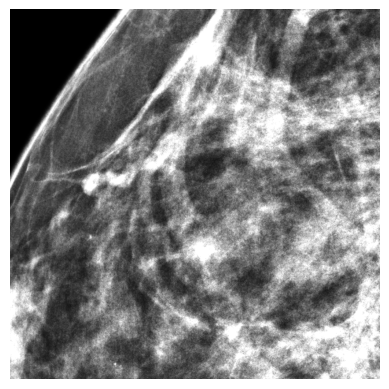

In [60]:
for i in range(len(df_pos)):
    crop_roi(df_pos.loc[i,:])